# Comp Econ Homework Set 4

**Author**: Chase Coleman

**NYU ID**: N10879183

**Due Date**: 4 March 2016

In [1]:
import numpy as np
np.set_printoptions(suppress=True, precision=4)

## Question

Recall HW set 1, where you showed the downward bias in the OLS estimate of $\alpha$ in the AR(1) process

$$X_{t+1} = \alpha X_{t} + \beta + \sigma W_{t+1}, \; \{W_t\} \sim N(0, 1)$$

Repeat this now in python using some of the tools from the scientific libraries. Set $\alpha = 0.5$ and compute an estimate of the bias for sample sizes $n = 50, 100, 150, \dots, 500$. Plot with $n$ on the horizontal axis and bias on the vertical axis.

Repeat (on the same figure) with $\alpha = 0.6, 0.7, 0.8, 0.9$.

Include your code in a Jupyter notebook that displays the resulting figure in the browser. Your notebook should not have external dependencies.

## Answer

Since this is simply a one dimensional regression. We will use a special formula that will allow us to compute the slope coefficient on the fly. In particular, for a one dimensional regression we know:

$$\hat{\alpha} = \frac{\sum_i x_i y_i - E[x] E[y]}{\sum x_i^2 - n E[x]^2}$$

Using this formula will allow us to get the regression coefficient without allocating memory for the simulation which for a large enough $T$ will make a difference.

We set the parameter values below and use them for the rest of the code

In [2]:
alphavals = np.array([0.6, 0.7, 0.8, 0.9])
Tvals = np.arange(50, 550, 50)
beta, sig, N = 0.0, 0.1, 10000

In order to maximize performance, we will take advantage of two packages found in Python:

* `numba`
* `multiprocessing`

We will try to isolate the benefits of each of the tools we use from these packages by writing and racing a few version of our code. We will write

1. vanilla python implementation (single-core)
2. vanilla python implementation (multi-core via `multiprocessing`)
3. `numba`-ized python implementation (single-core)
4. `numba`-ized python implementation (multi-core via `numba`)
5. `numba`-ized python implementation (multi-core via `multiprocessing`)

I could have written additional versions of the code with `cython`, but ran out of time.

### (1) Vanilla Python Implementation (single-core)

The first function we will write is `single_estimate_1` which simulates a single history of the AR(1) process and returns the estimated coefficient.

**Note:** If I really wanted to run this as fast as possible, I would vectorize `single_estimate_1`/`compute_bias_1` using `numpy` and do all `N` at once for each `T`. Come back if I feel like it.

In [3]:
def single_estimate_1(alpha, beta, sigma, T, seed=42):
    # Set seed
    np.random.seed(seed)
    
    # Variable that will be simulated
    x = 0.0
    y = 0.0
    
    # Create variables for computing coeff
    xi_yi= 0.0  # xi*yi
    xi2 = 0.0  # x^2
    nE_x = 0.0  # E[x]
    nE_y = 0.0  # E[y]
    
    # Go through simulation
    for t in range(T):
        # One step of AR(1)
        x = beta + alpha*y + sigma*np.random.randn()
        
        # Add to all our variables of interest
        xi_yi += x*y
        xi2 += x*x
        nE_x += x
        nE_y += y
        
        # Update y
        y = x
    
    # Use the specific formula that gives us the slope for 1 dim regression
    # alphahat = \frac{\sum (xi yi) - E[x] E[y]}{\sum xi^2 - 1/n E[x]^2}
    bias = (xi_yi - (1/T)*nE_x*nE_y) / (xi2 - (1/T)*nE_x**2) - alpha
    
    return bias

Next, we write two functions `compute_bias_1` and `compute_bias_allT_1`.

* `compute_bias_1` will compute the bias `N` times using `single_estimate_1` and returns the average bias. We are appealing to law of large numbers and claiming our estimate of the bias is converging to the true bias as `N` goes to infinity.
* `compute_bias_allT_1` will compute the bias `N` times for each value of `T` that it is given.

In [4]:
def compute_bias_1(alpha, beta, sig, T, N):
    # Place holder to put each element of bias
    bias_i = 0.0
    
    for i in range(N):
        bias_i += single_estimate_1(alpha, beta, sig, T, seed=i)
        
    return bias_i/N

def compute_bias_allT_1(alpha, beta, sig, Tvals, N):
    # Place holder for each bias
    nT = len(Tvals)
    biasT = np.empty(nT)
    
    for i in range(nT):
        biasT[i] = compute_bias_1(alpha, beta, sig, Tvals[i], N)
    
    return biasT

We can write `vanilla_python_single` to iterate over each value of $\alpha$ that we would like to perform this operation for.

In [5]:
def vanilla_python_single(alphavals, beta, sig, Tvals, N):
    # Place holders
    nalpha = len(alphavals)
    nT = len(Tvals)
    biases = np.empty((nalpha, nT))
    
    for i in range(nalpha):
        calp = alphavals[i]
        biases[i, :] = compute_bias_allT_1(calp, beta, sig, Tvals, N)
    
    return biases

In [6]:
time1 = %timeit -r 1 -n 1 -o vanilla_python_single(alphavals, beta, sig, Tvals, N)

1 loop, best of 1: 1min 25s per loop


### (2) Vanilla Python Implementation (multi-core)

We can re-use most of the functions we wrote for our single-core vanilla Python implementation. We will choose to parallelize over `T` -- We could have chosen other levels of parallelization.

We will only need to rewrite the `compute_bias_allT` function and the function which calls it. We will need to import `multiprocessing` and `repeat` from itertools

In [7]:
from itertools import repeat
import multiprocessing as mp


def compute_bias_allT_2(alpha, beta, sig, Tvals, N):
    # Need to repeat args that are scalars for starmap
    repargs = zip(repeat(alpha), repeat(beta),
                  repeat(sig), Tvals, repeat(N))
    
    # Create a Pool with 5 processes and run
    with mp.Pool(processes=5) as pool:
        biases = pool.starmap(compute_bias_1, repargs, chunksize=1)
        
    return np.array(biases)

We can now write a function which calls `compute_bias_allT_2` for each value of $\alpha$ just as we did previously.

In [8]:
def vanilla_python_multi(alphavals, beta, sig, Tvals, N):
    # Place holders
    nalpha = len(alphavals)
    nT = len(Tvals)
    biases = np.empty((nalpha, nT))
    
    for i in range(nalpha):
        calp = alphavals[i]
        biases[i, :] = compute_bias_allT_2(calp, beta, sig, Tvals, N)
    
    return biases

In [9]:
time2 = %timeit -r 1 -n 1 -o vanilla_python_multi(alphavals, beta, sig, Tvals, N)

1 loop, best of 1: 26.8 s per loop


### (3) Numba-ized Python (single-core)

Again, much of the work has been for us here in the previous version. We will just in time compile (jit) our `single_estimate_1` function and then rewrite (and jit) the other related functions.

We include the `nopython=True` specification in our `jit` command to ensure that the compiler never needs to reach into object mode (as opposed to compiled mode) -- `numba` tries to stay in compiled mode by default, but this option throws an error if it is unable to compile.

In [10]:
from numba import jit, vectorize, float64, int64


# Use python version to get a JITed version
single_estimate_3 = jit(single_estimate_1, nopython=True)


@jit(nopython=True)
def compute_bias_3(alpha, beta, sig, T, N):
    # Place holder to put each element of bias
    bias_i = 0.0
    
    for i in range(N):
        bias_i += single_estimate_3(alpha, beta, sig, T, i)
        
    return bias_i/N


@jit(nopython=True)
def compute_bias_allT_3(alpha, beta, sig, Tvals, N):
    # Place holder for each bias
    nT = len(Tvals)
    biasT = np.empty(nT)
    
    for i in range(nT):
        biasT[i] = compute_bias_3(alpha, beta, sig, Tvals[i], N)

    return biasT


def numba_python_single(alphavals, beta, sig, Tvals, N):
    # Place holders
    nalpha = len(alphavals)
    nT = len(Tvals)
    biases = np.empty((nalpha, nT))
    
    for i in range(nalpha):
        calp = alphavals[i]
        biases[i, :] = compute_bias_allT_3(calp, beta, sig, Tvals, N)
    
    return biases

In [11]:
time3 = %timeit -o numba_python_single(alphavals, beta, sig, Tvals, N)

1 loop, best of 3: 4.49 s per loop


### (4) Numba-ized Python (multi-core via numba)

`numba` can just in time compile functions in several ways. One way it is allowed to do so is by using the `vectorize` function.

`vectorize` creates a `ufunc` (a function which can be called on a scalar or an array). Additionally, `vectorize` will allow us to set `target=parallel` which will allow multiple processors to boot up. We are required to be specific about what types of arguments will come into vectorize.

**Note:** Something is going wrong when switching from `target=cpu` to `target=parallel`. It is failing to use right seeds and is repeating instead. Look into this (Doing same amount of work... Just not doing the right work). Don't use to compute actual bias

In [12]:
# Use python version to get a JITed version
single_estimate_4 = jit(single_estimate_1, nopython=True)

# This is a vectorized function so we can give it multiple
# values of T
@vectorize(['float64(float64, float64, float64, int64, int64)'],
           nopython=True, target='parallel')
def compute_bias_4(alpha, beta, sig, T, N):
    # Place holder to put each element of bias
    bias_i = 0.0
    
    for i in range(N):
        bias_i += single_estimate_4(alpha, beta, sig, T, i)
        
    return bias_i/N


def numba_python_multinumba(alphavals, beta, sig, Tvals, N):
    # Place holders
    nalpha = len(alphavals)
    nT = len(Tvals)
    biases = np.empty((nalpha, nT))
    
    for i in range(nalpha):
        calp = alphavals[i]
        biases[i, :] = compute_bias_4(calp, beta, sig, Tvals, N)

    return biases

In [13]:
time4 = %timeit -o numba_python_multinumba(alphavals, beta, sig, Tvals, N)

1 loop, best of 3: 3.35 s per loop


### (5) Numba-ized Python (multi-core via multiprocessing)

We will now use `multiprocessing` to farm off some of our jit-ted computations to various processors. The parallel piece of the code will look very similar to the vanilla python with multiple cores.

In [14]:
# Use python version to get a JITed version
single_estimate_5 = jit(single_estimate_1, nopython=True)


@jit(nopython=True)
def compute_bias_5(alpha, beta, sig, T, N):
    # Place holder to put each element of bias
    bias_i = 0.0
    
    for i in range(N):
        bias_i += single_estimate_5(alpha, beta, sig, T, i)
        
    return bias_i/N


def compute_bias_allT_5(alpha, beta, sig, Tvals, N):
    # Need to repeat args that are scalars for starmap
    repargs = zip(repeat(alpha), repeat(beta),
                  repeat(sig), Tvals, repeat(N))
    
    # Create a Pool with 5 processes and run
    with mp.Pool(processes=5) as pool:
        biasT = pool.starmap(compute_bias_5, repargs, chunksize=2)

    return np.array(biasT)


def numba_python_multimp(alphavals, beta, sig, Tvals, N):
    # Place holders
    nalpha = len(alphavals)
    nT = len(Tvals)
    biases = np.empty((nalpha, nT))
    
    for i in range(nalpha):
        calp = alphavals[i]
        biases[i, :] = compute_bias_allT_5(calp, beta, sig, Tvals, N)
    
    return biases

In [15]:
time5 = %timeit -o numba_python_multimp(alphavals, beta, sig, Tvals, N)

1 loop, best of 3: 2.67 s per loop


In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline

### Display Timings

In [17]:
times = [time1, time2, time3, time4, time5]
method = ["Vanilla Python", "Multiprocessing Python",
          "Numba Python", "Numba Vectorize Python",
         "Numba Multiprocessing Python"]
df = pd.DataFrame(np.array([x.best for x in times]),
                  index=method, columns=["Time"])

print(df)

                                   Time
Vanilla Python                85.217555
Multiprocessing Python        26.838526
Numba Python                   4.490973
Numba Vectorize Python         3.347666
Numba Multiprocessing Python   2.672677



## Plot Bias

In [18]:
def create_downward_bias_plot(alphavals, beta, sig, Tvals, N):
    # Get bias
    bias = numba_python_multimp(alphavals, beta, sig, Tvals, N)

    # Create subplot
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot biases
    ax.plot(Tvals, bias.T)

    ax.legend(alphavals, loc=2)
    ax.set_xlabel("Time")
    ax.set_ylabel(r"$E[\hat{\alpha}] - \alpha$")
    ax.set_title("Downward Bias in AR(1) Coefficient")
    
    return fig

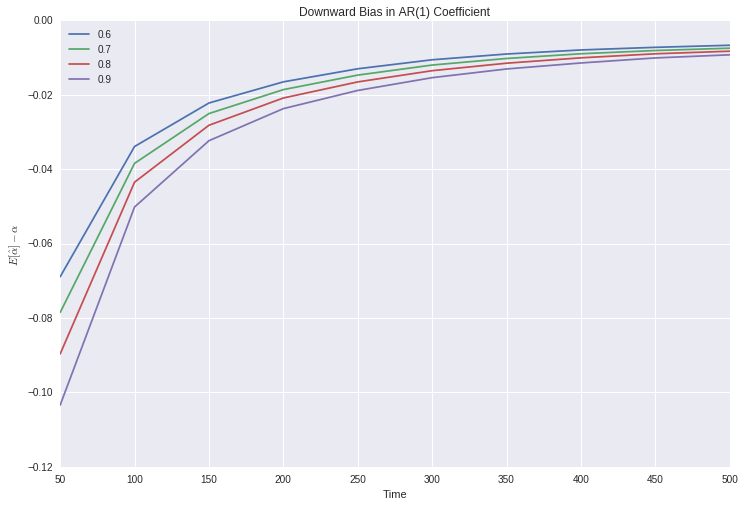

In [19]:
f = create_downward_bias_plot(alphavals, beta, sig, Tvals, N)

Notice that the biases moves toward 0 as we move time towards infinity. This is because of the consistency properties of OLS for the AR(1).

Additionally, one could note that the bias is more pronounced the more persistent the process is.